In [1]:
# Import de la bibliothèque essentielle pour la manipulation de données
import pandas as pd

# On définit des noms de colonnes clairs
column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Chargement des données dans un "DataFrame"
df = pd.read_csv("./input/training.1600000.processed.noemoticon.csv", names=column_names, encoding="latin-1")

# On remplace la valeur 4 par 1 dans la colonne 'sentiment' pour la rendre binaire (0 ou 1)
df['sentiment'] = df['sentiment'].replace(4, 1)

# Affichage des 5 premières lignes pour un premier aperçu
print("Aperçu des 5 premières lignes du tableau de données :")
print(df.head())

Aperçu des 5 premières lignes du tableau de données :
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [2]:
df.describe()

,sentiment,id
count,1600000.0,1.600000e+06
mean,0.5,1.998818e+09
std,0.5,1.935761e+08
min,0.0,1.467810e+09
25%,0.0,1.956916e+09
50%,0.5,2.002102e+09
75%,1.0,2.177059e+09
max,1.0,2.329206e+09


In [3]:
# 1. Obtenir les dimensions du tableau (nombre de lignes, nombre de colonnes)
print(f"Dimensions du tableau : {df.shape}")
print("-" * 30)

# 2. Obtenir un résumé des informations (types de données, valeurs non nulles)
print("Informations sur le DataFrame :")
df.info()
print("-" * 30)

# 3. Compter le nombre de tweets pour chaque sentiment
# La colonne 'is_negative' contient notre label : 1 pour négatif, 0 pour non-négatif
print("Distribution des sentiments :")
print(df['sentiment'].value_counts())

Dimensions du tableau : (1600000, 6)
------------------------------
Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
------------------------------
Distribution des sentiments :
sentiment
0    800000
1    800000
Name: count, dtype: int64


In [4]:
import re
import string # A pre-built list of all punctuation marks


# This function removes the three main types of "noise"
def clean_text(text):
    text = re.sub(r'https://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)                # Remove mentions
    text = re.sub(r'#', '', text)                   # Remove the '#' symbol
    text = text.lower()                            # Convert to lowercase
    # Remove all characters that are in the string.punctuation list
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) 
    return text

# We apply this function to every tweet in the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Let's check the result on one example
print("Original text: ", df['text'].iloc[0])
print("Cleaned text:  ", df['cleaned_text'].iloc[0])

Original text:  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Cleaned text:    httptwitpiccom2y1zl  awww thats a bummer  you shoulda got david carr of third day to do it d


In [5]:
# We'll use a popular library for this called NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# These lines download the necessary tools from NLTK (you only need to run them once)
nltk.download('punkt')
nltk.download('stopwords')

# Load the list of English stop words
stop_words = set(stopwords.words('english'))

# Apply tokenization and stop word removal
df['tokens'] = df['cleaned_text'].apply(lambda text: [word for word in word_tokenize(text) if word not in stop_words])

# Let's check our example one last time
print("Cleaned text:", df['cleaned_text'].iloc[0])
print("Final tokens:", df['tokens'].iloc[0])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned text:  httptwitpiccom2y1zl  awww thats a bummer  you shoulda got david carr of third day to do it d
Final tokens: ['httptwitpiccom2y1zl', 'awww', 'thats', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# The vectorizer needs sentences, so we join our tokens back into a single string
df['final_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer
# We'll limit it to the 5,000 most important words to keep it efficient
vectorizer = TfidfVectorizer(max_features=5000)

# Create the numerical feature matrix X by applying the vectorizer
X = vectorizer.fit_transform(df['final_text'])

# Define our target variable y (the sentiment column)
y = df['sentiment']

# Check the final shapes
print("Shape of our feature matrix X:", X.shape)
print("Shape of our target vector y:", y.shape)

Shape of our feature matrix X: (1600000, 5000)
Shape of our target vector y: (1600000,)


In [7]:
from sklearn.model_selection import train_test_split

# Split our data X and our labels y
# test_size=0.2 means 20% of the data is reserved for testing
# random_state=42 ensures we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Let's print the shapes to see the result
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1280000, 5000)
Testing data shape: (320000, 5000)


In [8]:
from sklearn.linear_model import LogisticRegression

# 1. Create an instance of the model
# We increase max_iter to ensure the model has enough time to learn from the large dataset
model = LogisticRegression(max_iter=1000)

# 2. Train the model using our training data (X_train, y_train)
print("Training the model...")
model.fit(X_train, y_train)
print("Model training is complete!")

Training the model...
Model training is complete!


In [9]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Use the trained model to make predictions on the test data
print("Making predictions on the test data...")
y_pred = model.predict(X_test)

# 2. Compare the model's predictions (y_pred) with the true answers (y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.2f}")

# 3. Get a more detailed performance report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-négatif (0)', 'Négatif (1)']))

Making predictions on the test data...

Overall Accuracy: 0.77

Classification Report:
                 precision    recall  f1-score   support

Non-négatif (0)       0.78      0.75      0.77    159494
    Négatif (1)       0.76      0.80      0.78    160506

       accuracy                           0.77    320000
      macro avg       0.77      0.77      0.77    320000
   weighted avg       0.77      0.77      0.77    320000



In [10]:
# We'll use the same powerful libraries as before
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# The correct, English-based model name
model_name = "distilbert-base-uncased"

# 1. Load the Tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Load the DistilBERT model for sequence classification (with 2 labels)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print("DistilBERT model and its tokenizer are loaded and ready!")

c:\formations\ingénieur ia\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model and its tokenizer are loaded and ready!


In [11]:
# A sample tweet from our dataset
sample_text = "i love the new flight attendant service"

# Use the tokenizer to process the text
# padding='max_length' and truncation=True ensure all sentences are the same size
encoding = tokenizer(sample_text, 
                     padding='max_length', 
                     truncation=True, 
                     max_length=64, # A common length for tweets
                     return_tensors='pt') # Return as PyTorch tensors

print("Original Sentence:\n", sample_text)
print("\nToken IDs (input_ids):\n", encoding['input_ids'])
print("\nAttention Mask:\n", encoding['attention_mask'])

Original Sentence:
 i love the new flight attendant service

Token IDs (input_ids):
 tensor([[  101,  1045,  2293,  1996,  2047,  3462, 16742,  2326,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])

Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [12]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Let's create a smaller, manageable sample of our data for this demo
sample_df = df.sample(n=16000, random_state=42)

# Create an instance of our custom Dataset
MAX_LEN = 64
sentiment_dataset = SentimentDataset(
    texts=sample_df.text.to_numpy(),
    labels=sample_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [13]:
from torch.utils.data import DataLoader, random_split
import numpy as np

# 1. Split the main dataset
train_size = int(0.8 * len(sentiment_dataset))
test_size = len(sentiment_dataset) - train_size
train_dataset, test_dataset = random_split(sentiment_dataset, [train_size, test_size])

# 2. Create the DataLoaders for each set
BATCH_SIZE = 16

train_data_loader = DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE
)

print(f"Number of batches in the training loader: {len(train_data_loader)}")
print(f"Number of batches in the testing loader: {len(test_data_loader)}")

Number of batches in the training loader: 800
Number of batches in the testing loader: 200


In [14]:
from torch.optim import AdamW
from tqdm.auto import tqdm # For a nice progress bar

# 1. SETUP
# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5) # lr is the learning rate

# 2. TRAINING LOOP
model.train() # Set the model to training mode
for batch in tqdm(train_data_loader):
    # Move batch data to the correct device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Forward pass: get model outputs
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    
    # Get the loss (the measure of error)
    loss = outputs.loss
    
    # Backward pass: calculate gradients
    loss.backward()
    
    # Update weights
    optimizer.step()
    optimizer.zero_grad()

# 3. EVALUATION LOOP
model.eval() # Set the model to evaluation mode
# ... similar loop over the test_data_loader, but without the optimizer steps ...
# We would collect all predictions and then calculate accuracy, precision, and recall.

100%|██████████| 800/800 [30:31<00:00,  2.29s/it]


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
from torch.optim import AdamW
from tqdm.auto import tqdm # Pour une belle barre de progression
import torch
from sklearn.metrics import classification_report
import numpy as np

# Listes pour stocker les métriques
history = {
    'train_loss': [],
    'val_accuracy': []
}

# 1. PRÉPARATION
# Déplace le modèle sur le GPU si disponible, sinon le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialise l'optimiseur, qui met à jour les poids du modèle
optimizer = AdamW(model.parameters(), lr=2e-5)

# Nombre d'époques (cycles d'entraînement complets)
EPOCHS = 4

# 2. BOUCLE D'ENTRAÎNEMENT PRINCIPALE
for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1} / {EPOCHS} ---')
    
    # -- Phase d'entraînement --
    model.train() # Passe le modèle en mode "entraînement"
    total_train_loss = 0

    for batch in tqdm(train_data_loader, desc="Training"):
        # Déplace les données du batch sur le bon appareil (CPU ou GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Réinitialise les gradients de l'itération précédente
        optimizer.zero_grad()
        
        # Le modèle traite les données et calcule la perte (l'erreur)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Rétropropagation : calcule comment ajuster les poids pour réduire l'erreur
        loss.backward()
        
        # L'optimiseur applique les ajustements aux poids du modèle
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_data_loader)
    history['train_loss'].append(avg_train_loss)

    # -- Phase d'évaluation --
    print("Evaluating...")
    model.eval() # Passe le modèle en mode "évaluation"
    
    predictions, true_labels = [], []
    
    with torch.no_grad(): # Pas besoin de calculer les gradients pendant l'évaluation
        for batch in tqdm(test_data_loader, desc="Evaluating"):
            # Déplace les données du batch sur le bon appareil
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Le modèle fait ses prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # On récupère la prédiction la plus probable (0 ou 1)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1)
            
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(true_labels, predictions)
    history['val_accuracy'].append(val_accuracy)

    # Affiche le rapport de classification pour l'époch en cours
    print(f"\nRésultats pour l'Epoch {epoch + 1}:")
    print(classification_report(true_labels, predictions, target_names=['Positif (0)', 'Négatif (1)']))

print("\nEntraînement terminé !")

--- Epoch 1 / 4 ---


Training: 100%|██████████| 800/800 [5:49:38<00:00, 26.22s/it]      


Evaluating...


Evaluating: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s]



Résultats pour l'Epoch 1:
              precision    recall  f1-score   support

 Positif (0)       0.81      0.82      0.81      1607
 Négatif (1)       0.81      0.80      0.81      1593

    accuracy                           0.81      3200
   macro avg       0.81      0.81      0.81      3200
weighted avg       0.81      0.81      0.81      3200

--- Epoch 2 / 4 ---


Training: 100%|██████████| 800/800 [8:55:22<00:00, 40.15s/it]       


Evaluating...


Evaluating: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s]



Résultats pour l'Epoch 2:
              precision    recall  f1-score   support

 Positif (0)       0.76      0.88      0.81      1607
 Négatif (1)       0.85      0.72      0.78      1593

    accuracy                           0.80      3200
   macro avg       0.80      0.80      0.80      3200
weighted avg       0.80      0.80      0.80      3200

--- Epoch 3 / 4 ---


Training: 100%|██████████| 800/800 [23:40<00:00,  1.78s/it]


Evaluating...


Evaluating: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]



Résultats pour l'Epoch 3:
              precision    recall  f1-score   support

 Positif (0)       0.86      0.73      0.79      1607
 Négatif (1)       0.77      0.88      0.82      1593

    accuracy                           0.80      3200
   macro avg       0.81      0.80      0.80      3200
weighted avg       0.81      0.80      0.80      3200

--- Epoch 4 / 4 ---


Training: 100%|██████████| 800/800 [23:17<00:00,  1.75s/it]


Evaluating...


Evaluating: 100%|██████████| 200/200 [01:26<00:00,  2.32it/s]


Résultats pour l'Epoch 4:
              precision    recall  f1-score   support

 Positif (0)       0.82      0.81      0.82      1607
 Négatif (1)       0.81      0.82      0.82      1593

    accuracy                           0.82      3200
   macro avg       0.82      0.82      0.82      3200
weighted avg       0.82      0.82      0.82      3200


Entraînement terminé !


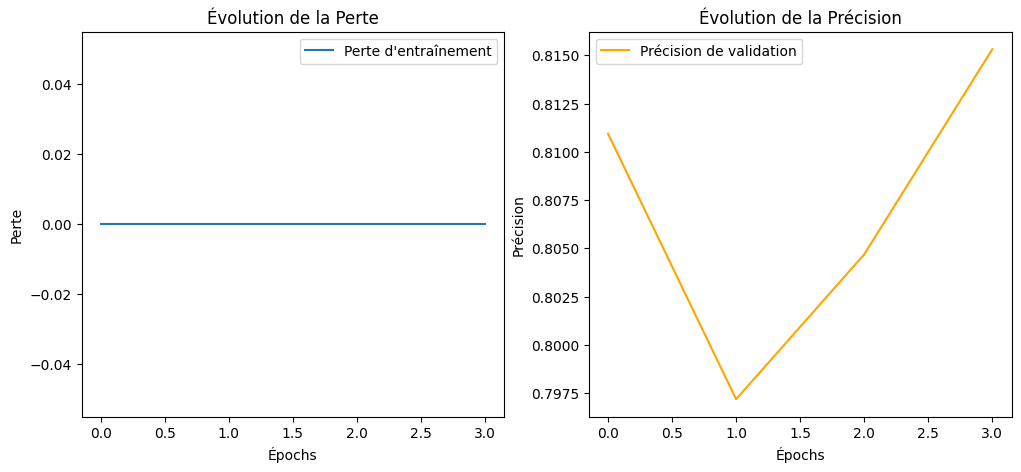

In [18]:
import matplotlib.pyplot as plt

# Créer une figure avec deux graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Graphique de la perte d'entraînement
ax1.plot(history['train_loss'], label='Perte d\'entraînement')
ax1.set_title('Évolution de la Perte')
ax1.set_xlabel('Épochs')
ax1.set_ylabel('Perte')
ax1.legend()

# Graphique de la précision de validation
ax2.plot(history['val_accuracy'], label='Précision de validation', color='orange')
ax2.set_title('Évolution de la Précision')
ax2.set_xlabel('Épochs')
ax2.set_ylabel('Précision')
ax2.legend()

plt.show()

In [ ]:
import os

# 1. Définir le chemin du répertoire où tout sera sauvegardé
output_dir = "../sentiment_distilbert_model/"

# Crée le répertoire s'il n'existe pas
os.makedirs(output_dir, exist_ok=True)

print(f"Sauvegarde du modèle dans le répertoire {output_dir}")

# 2. Sauvegarder le modèle (uniquement ses poids appris)
model.save_pretrained(output_dir)

# 3. Sauvegarder le tokenizer associé
tokenizer.save_pretrained(output_dir)

print("\nModèle et tokenizer sauvegardés avec succès !")

Sauvegarde du modèle dans le répertoire ./sentiment_distilbert_model/

Modèle et tokenizer sauvegardés avec succès !


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 1. Définir le chemin où se trouve le modèle sauvegardé
output_dir = "../sentiment_distilbert_model/"

# 2. Charger le tokenizer depuis ce répertoire
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# 3. Charger le modèle depuis ce répertoire
model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Mettons le modèle en mode évaluation (important !)
model.eval()

# 4. Utiliser le modèle pour une nouvelle prédiction
new_tweet = "The flight was surprisingly on time and the crew was wonderful."

# Préparer le tweet avec le tokenizer (comme pendant l'entraînement)
inputs = tokenizer(new_tweet, return_tensors="pt", truncation=True, padding=True)

# Faire la prédiction
with torch.no_grad(): # Pas besoin de calculer les gradients pour une simple prédiction
    outputs = model(**inputs)

# Obtenir le résultat
logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Interpréter le résultat
sentiments = ['Négatif (0)', 'Positif (1)']
print(f"Le tweet : '{new_tweet}'")
print(f"Result: {prediction}")
print(f"Prédiction : {sentiments[prediction]}")

c:\formations\ingénieur ia\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Le tweet : 'The flight was surprisingly on time and the crew was wonderful.'
Result: 1
Prédiction : Positif (1)
